
## PS1-1 Linear Classifiers (logistic regression and GDA)

#### (a)

Recall the average empirical loss for logistic regression:

$$J(\theta) = - \frac{1}{m} \sum_{i = 1}^{m} y^{(i)} \log \big( h_\theta (x^{(i)}) \big) + (1 - y^{(i)}) \log \big( 1 - h_\theta (x^{(i)}) \big)$$,

where $y^{(i)} \in \{ 0, 1 \}, h_\theta (x) = g(\theta^T x)$ and $g(z) = 1 / (1 + e^{-z})$.

Compute the gradient of $J(\theta)$:

\begin{align*}
\nabla_\theta J(\theta) & = - \frac{1}{m} \sum_{i = 1}^{m} y^{(i)} \frac{1}{h_\theta (x^{(i)})} h_\theta (x^{(i)}) \big( 1 - h_\theta (x^{(i)}) \big) - (1 - y^{(i)}) \frac{1}{1 - h_\theta (x^{(i)})} h_\theta (x^{(i)}) \big( 1 - h_\theta (x^{(i)}) \big) \\
                        & = - \frac{1}{m} \sum_{i = 1}^{m} \big( y^{(i)} - h_\theta (x^{(i)}) \big) x^{(i)}
\end{align*}

Then, the Hessian of $J(\theta)$ is:

$$H = \nabla_\theta^2 J(\theta) = \frac{1}{m} \sum_{i = 1}^{m}  h_\theta (x^{(i)}) \big( 1 - h_\theta (x^{(i)}) \big) x^{(i)} (x^{(i)})^T$$

And for any $z \in \mathbb{R}^n$:

\begin{align*}
z^T H z & = \sum_{j = 1}^{n} \sum_{k = 1}^{n} H_{jk} z_j z_k \\
        & = \sum_{j = 1}^{n} \sum_{k = 1}^{n} \frac{1}{m} \sum_{i = 1}^{m}  h_\theta (x^{(i)}) \big( 1 - h_\theta (x^{(i)}) \big) x_j^{(i)} x_k^{(i)} z_j z_k \\
        & = \frac{1}{m} \sum_{i = 1}^{m}  h_\theta (x^{(i)}) \big( 1 - h_\theta (x^{(i)}) \big) \sum_{j = 1}^{n} \sum_{k = 1}^{n} z_j x_j^{(i)} x_k^{(i)} z_k \\
        & = \frac{1}{m} \sum_{i = 1}^{m}  h_\theta (x^{(i)}) \big( 1 - h_\theta (x^{(i)}) \big) \big( (x^{(i)})^T z \big)^2 \\
        & \geq 0
\end{align*}

#### (b)

In [1]:
import os
import sys
print(os.path.abspath('..'))
sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
import numpy as np
import problem_set_1.src.util as util

from problem_set_1.src.linear_model import LinearModel

C:\Users\Administrator\Desktop\Course\CS229\cs229-solutions-fall2018-main


In [2]:
ds1_training_set_path = 'data/ds1_train.csv'
ds1_valid_set_path = 'data/ds1_valid.csv'
ds2_training_set_path = 'data/ds2_train.csv'
ds2_valid_set_path = 'data/ds2_valid.csv'

In [3]:
x_train, y_train = util.load_dataset(ds1_training_set_path, add_intercept=True)
x_valid, y_valid = util.load_dataset(ds1_valid_set_path, add_intercept=True)

Take a look at the training set:

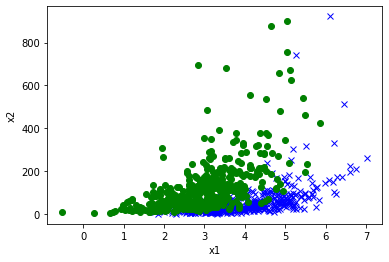

In [4]:
plt.xlabel('x1')
plt.ylabel('x2')
plt.plot(x_train[y_train == 1, -2], x_train[y_train == 1, -1], 'bx', linewidth=2)
plt.plot(x_train[y_train == 0, -2], x_train[y_train == 0, -1], 'go', linewidth=2)


Implement logistic regression using Newton's Method:

In [5]:
class LogisticRegression(LinearModel):
    """Logistic regression with Newton's Method as the solver.

    Example usage:
        > clf = LogisticRegression()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Run Newton's Method to minimize J(theta) for logistic regression.

        :param x: Training example inputs. Shape (m, n).
        :param y: Training example labels. Shape (m,).
        """

        def h(theta, x):
            """Vectorized implementation of h_theta(x) = 1 / (1 + exp(-theta^T x)).

            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :return:      The hypothesis for all training examples. Shape (m,).
            """
            return 1 / (1 + np.exp(-np.dot(x, theta)))

        def gradient(theta, x, y):
            """Vectorized implementation of the gradient of J(theta).

            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :param y:     All labels of shape (m,).
            :return:      The gradient of shape (n,).
            """
            m, _ = x.shape
            return -1 / m * np.dot(x.T, (y - h(theta, x)))

        def hessian(theta, x):
            """Vectorized implementation of the Hessian of J(theta).

            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :return:      The Hessian of shape (n, n).
            """
            m, _ = x.shape
            h_theta_x = np.reshape(h(theta, x), (-1, 1))
            return 1 / m * np.dot(x.T, h_theta_x * (1 - h_theta_x) * x)

        def next_theta(theta, x, y):
            """The next theta updated by Newton's Method.

            :param theta: Shape (n,).
            :return:      The updated theta of shape (n,).
            """
            return theta - np.dot(np.linalg.inv(hessian(theta, x)), gradient(theta, x, y))

        m, n = x.shape

        # Initialize theta
        if self.theta is None:
            self.theta = np.zeros(n)

        # Update theta using Newton's Method
        old_theta = self.theta
        new_theta = next_theta(self.theta, x, y)
        while np.linalg.norm(new_theta - old_theta, 1) >= self.eps:
            old_theta = new_theta
            new_theta = next_theta(old_theta, x, y)

        self.theta = new_theta

    def predict(self, x):
        """Make a prediction given new inputs x.

        :param x: Inputs of shape (m, n).
        :return:  Outputs of shape (m,).
        """

        return x @ self.theta >= 0

Train the logistic regression model:

In [6]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

Plot decision boundary for training set:

Theta is:  [-6.26018491  2.47707251 -0.0299125 ]
The accuracy on training set is:  0.8825


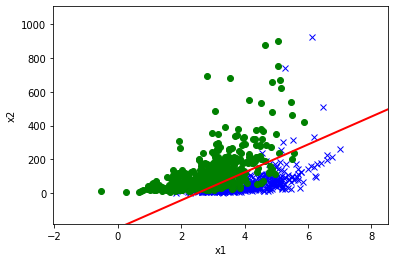

In [7]:
util.plot(x_train, y_train, theta=log_reg.theta)
print("Theta is: ", log_reg.theta)
print("The accuracy on training set is: ", np.mean(log_reg.predict(x_train) == y_train))

Plot decision boundary for validation set:

The accuracy on validation set is:  0.9


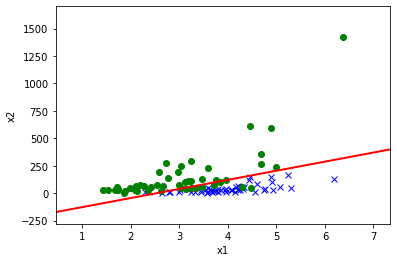

In [8]:
util.plot(x_valid, y_valid, log_reg.theta)
print("The accuracy on validation set is: ", np.mean(log_reg.predict(x_valid) == y_valid))

#### (c)

\begin{align*}
p(y = 1 \ \vert \ x; \ \phi, \mu_0, \mu_1, \Sigma) & = \frac{p(x\ \vert \ y = 1; \ \mu_0, \mu_1, \Sigma) \ p(y = 1; \ \phi)}{p(x\ \vert \ y = 1; \ \mu_0, \mu_1, \Sigma) \ p(y = 1; \ \phi) + p(x\ \vert \ y = 0; \ \mu_0, \mu_1, \Sigma) \ p(y = 0; \ \phi)} \\
                                                   & = 1 / (1 + \frac{p(x\ \vert \ y = 0; \ \mu_0, \mu_1, \Sigma) \ p(y = 0; \ \phi)}{p(x\ \vert \ y = 1; \ \mu_0, \mu_1, \Sigma) \ p(y = 1; \ \phi)}) \\
                                                   & = 1 / (1 + \exp \big( \frac{1}{2} (x - \mu_1)^T \Sigma^{-1} (x - \mu_1) - \frac{1}{2} (x - \mu_0)^T \Sigma^{-1} (x - \mu_0) \big) \frac{1 - \phi}{\phi}) \\
                                                   & = 1 / (1 + \exp \big( - \big( (\mu_1 - \mu_0)^T \Sigma^{-1} x + (\mu_0^T \Sigma^{-1} \mu_0 - \mu_1^T \Sigma^{-1} \mu_1 - \log \frac{1 - \phi}{\phi}) \big) \big) ) \\
                                                   & = 1 / (1 + \exp \big( -(\theta^T x + \theta_0) \big))
\end{align*}

where $\theta = \Sigma^{-1} (\mu_1 - \mu_0)$ and $\theta_0 = \mu_0^T \Sigma^{-1} \mu_0 - \mu_1^T \Sigma^{-1} \mu_1 - \log \frac{1 - \phi}{\phi}$.

#### (d)

To compute $\phi$, $\mu_0$ and $\mu_1$, recall the log-likelihood:

\begin{align*}
\ell(\phi, \mu_0, \mu_1, \Sigma) & = \log \prod_{i = 1}^{m} p(x^{(i)}, y^{(i)}; \ \phi, \mu_0, \mu_1, \Sigma) \\
                                 & = \log \prod_{i = 1}^{m} p(x^{(i)} \ \vert \ y^{(i)}; \ \mu_0, \mu_1, \Sigma) \ p(y^{(i)}; \ \phi) \\
                                 & = \log \prod_{i = 1}^{m} \big( p(x^{(i)} \ \vert \ y^{(i)} = 1; \ \mu_0, \mu_1, \Sigma) \ p(y^{(i)} = 1; \ \phi) \big) ^{1 \{ y^{(i)} = 1 \}} \big( p(x^{(i)} \ \vert \ y^{(i)} = 0; \ \mu_0, \mu_1, \Sigma) \ p(y^{(i)} = 0; \ \phi) \big) ^{1 \{ y^{(i)} = 0 \}} \\
                                 & = \sum_{i = 1}^{m} 1 \{ y^{(i)} = 1 \} \big( -\frac{1}{2} (x^{(i)} - \mu_1)^T \Sigma^{-1} (x^{(i)} - \mu_1) + \log \phi \big) + \sum_{i = 1}^{m} 1 \{ y^{(i)} = 0 \} \big( -\frac{1}{2} (x^{(i)} - \mu_0)^T \Sigma^{-1} (x^{(i)} - \mu_0) + \log (1 - \phi) \big) + C
\end{align*}

where $C$ does not contain $\phi$, $\mu_0$ or $\mu_1$.

Take derivative of $\ell$ w.r.t $\phi$ and set to 0:

\begin{align*}
\frac{\partial}{\partial \phi} \ell(\phi, \mu_0, \mu_1, \Sigma) & = \sum_{i = 1}^{m} 1 \{ y^{(i)} = 1 \} \frac{1}{\phi} + (m - \sum_{i = 1}^{m} 1 \{ y^{(i)} = 1 \}) \frac{1}{1 - \phi} \\
                                                                & = 0
\end{align*}

We have $\phi = \frac{1}{m} \sum_{i = 1}^{m} 1 \{ y^{(i)} = 1 \}$.

Also, take derivative of $\ell$ w.r.t $\mu_0$ and set to 0:

\begin{align*}
\frac{\partial}{\partial \mu_0} \ell(\phi, \mu_0, \mu_1, \Sigma) & = \sum_{i = 1}^{m} 1 \{ y^{(i)} = 0 \} \Sigma^{-1} (x^{(i)} - \mu_0) \\
                                                                 & = 0
\end{align*}

We can easily obtain that $\mu_0 = \sum_{i = 1}^{m} 1 \{ y^{(i)} = 0\} x^{(i)} / \sum_{i = 1}^{m} 1 \{ y^{(i)} = 0\}$. Similarly, $\mu_1 = \sum_{i = 1}^{m} 1 \{ y^{(i)} = 1\} x^{(i)} / \sum_{i = 1}^{m} 1 \{ y^{(i)} = 1\}$.

To compute $\Sigma$, even if $n \neq 1$, since

\begin{align*}
\det (A^{-1}) & = \frac{1}{\det (A)} \\
\frac{\partial}{\partial A} \log \vert A \vert & = A^{-T}
\end{align*}

we have

\begin{align*}
\Sigma & = \arg \max_{\Sigma} \ell(\phi, \mu_0, \mu_1, \Sigma) \\
       & = \arg \max_{\Sigma} \log \prod_{i = 1}^{m} p(x^{(i)} \ \vert \ y^{(i)}; \ \mu_0, \mu_1, \Sigma) \ p(y^{(i)}; \ \phi) \\
       & = \arg \max_{\Sigma} - \frac{m}{2} \log \vert \Sigma \vert - \frac{1}{2} \sum_{i = 1}^{m} (x^{(i)} - \mu_{y^{(i)}})^T \Sigma^{-1} (x^{(i)} - \mu_{y^{(i)}}) + C \\
       & = \arg_{\Sigma} \frac{\partial}{\partial \Sigma} \big( - \frac{m}{2} \log \vert \Sigma \vert - \frac{1}{2} \sum_{i = 1}^{m} \mathrm{tr}[(x^{(i)} - \mu_{y^{(i)}})^T \Sigma^{-1} (x^{(i)} - \mu_{y^{(i)}})] \big) = 0 \\
       & = \arg_{\Sigma} \frac{\partial}{\partial \Sigma} \big( - \frac{m}{2} \log \vert \Sigma \vert - \frac{1}{2} \sum_{i = 1}^{m} \mathrm{tr}[\Sigma^{-1} (x^{(i)} - \mu_{y^{(i)}}) (x^{(i)} - \mu_{y^{(i)}})^T] \big) = 0 \\
       & = \arg_{\Sigma} \frac{\partial}{\partial \Sigma^{-1}} \big( \frac{m}{2} \log \vert \Sigma^{-1} \vert - \frac{1}{2} \sum_{i = 1}^{m} \mathrm{tr}[\Sigma^{-1} (x^{(i)} - \mu_{y^{(i)}}) (x^{(i)} - \mu_{y^{(i)}})^T] \big) = 0 \\
       & = \arg_{\Sigma} \big( \frac{m}{2} \Sigma - \frac{1}{2} \sum_{i = 1}^{m} (x^{(i)} - \mu_{y^{(i)}}) (x^{(i)} - \mu_{y^{(i)}})^T \big) = 0 \\
       & = \frac{1}{m} \sum_{i = 1}^{m} (x^{(i)} - \mu_{y^{(i)}}) (x^{(i)} - \mu_{y^{(i)}})^T
\end{align*}

#### (e)

Implement GDA model:

In [9]:
class GDA(LinearModel):
    """Gaussian Discriminant Analysis.

    Example usage:
        > clf = GDA()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Fit a GDA model to training set given by x and y.

        :param x: Training example inputs. Shape (m, n).
        :param y: Training example labels. Shape (m,).
        """

        m, n = x.shape

        phi = np.sum(y) / m
        mu_0 = np.dot(x.T, 1 - y) / np.sum(1 - y)
        mu_1 = np.dot(x.T, y) / np.sum(y)

        # Reshape y to compute pairwise product with mu
        y_reshaped = np.reshape(y, (m, -1))

        # Matrix comprises mu_0 and mu_1 based on the value of y. Shape(m, n)
        mu_x = y_reshaped * mu_1 + (1 - y_reshaped) * mu_0

        x_centered = x - mu_x

        sigma = np.dot(x_centered.T, x_centered) / m
        sigma_inv = np.linalg.inv(sigma)

        # Compute theta and theta_0 according to the conclusion from part (c)
        theta = np.dot(sigma_inv, mu_1 - mu_0)
        theta_0 = 1 / 2 * mu_0 @ sigma_inv @ mu_0 - 1 / 2 * mu_1 @ sigma_inv @ mu_1 - np.log((1 - phi) / phi)

        self.theta = np.insert(theta, 0, theta_0)

    def predict(self, x):
        """Make a prediction given new inputs x.

        :param x: Inputs of shape (m, n).
        :return:  Outputs of shape (m,).
        """

        # Add x_0 = 1 convention to make predictions using theta^T x >= 0
        return util.add_intercept(x) @ self.theta >= 0

#### (f)

Rewrite `plot` function to allow a second decision boundary:

In [10]:
def plot(x, y, theta_1, legend_1=None, theta_2=None, legend_2=None, title=None, correction=1.0):
    # Plot dataset
    plt.figure()
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2)
    plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2)

    # Plot decision boundary (found by solving for theta_1^T x = 0)
    x1 = np.arange(min(x[:, -2]), max(x[:, -2]), 0.01)
    x2 = -(theta_1[0] / theta_1[2] * correction + theta_1[1] / theta_1[2] * x1)
    plt.plot(x1, x2, c='red', label=legend_1, linewidth=2)

    # Plot decision boundary (found by solving for theta_2^T x = 0)
    if theta_2 is not None:
        x1 = np.arange(min(x[:, -2]), max(x[:, -2]), 0.01)
        x2 = -(theta_2[0] / theta_1[2] * correction + theta_2[1] / theta_2[2] * x1)
        plt.plot(x1, x2, c='black', label=legend_2, linewidth=2)

    # Add labels, legend and title
    plt.xlabel('x1')
    plt.ylabel('x2')
    if legend_1 is not None or legend_2 is not None:
        plt.legend(loc="upper left")
    if title is not None:
        plt.suptitle(title, fontsize=12)

Load dataset 1 and drop the "$x_0 = 1$" convention:

In [11]:
x_train, y_train = util.load_dataset(ds1_training_set_path)
x_valid, y_valid = util.load_dataset(ds1_valid_set_path)

Train GDA model using dataset 1:

In [12]:
gda = GDA()
gda.fit(x_train, y_train)

Plot decision boundaries found by logistic regression and GDA on validation set:

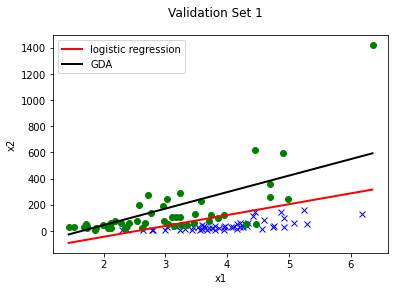

In [13]:
plot(x_valid, y_valid, theta_1=log_reg.theta, legend_1='logistic regression', theta_2=gda.theta, legend_2='GDA', title='Validation Set 1')

GDA performs worse than logistic regression on dataset 1 as expected.

#### (g)

Repeat the steps in part (f) for dataset 2:

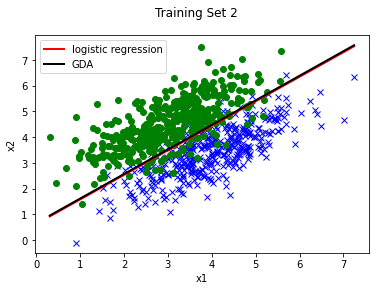

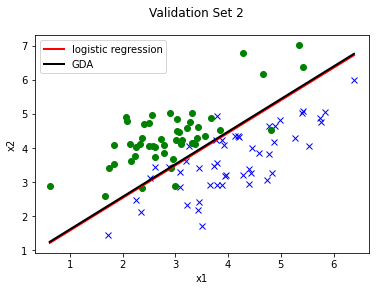

In [14]:
# Train logistic regression
x_train, y_train = util.load_dataset(ds2_training_set_path, add_intercept=True)
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

# Train GDA
x_train, y_train = util.load_dataset(ds2_training_set_path)
gda = GDA()
gda.fit(x_train, y_train)

# Plot decision boundaries on training set 2
plot(x_train, y_train, theta_1=log_reg.theta, legend_1='logistic regression', theta_2=gda.theta, legend_2='GDA', title='Training Set 2')

# Plot decision boundaries on validation set 2
x_valid, y_valid = util.load_dataset(ds2_valid_set_path)
plot(x_valid, y_valid, theta_1=log_reg.theta, legend_1='logistic regression', theta_2=gda.theta, legend_2='GDA', title='Validation Set 2')

For dataset 2, logistic regression and GDA have same performance.

#### (g)

GDA performs poorly on dataset 1 but OK on dataset 2. The reason is that GDA assumes $p(x \ \vert \ y)$ is Gaussian, whereas dataset 1 is non-Gaussian.

Take a look at dataset 1, we find that all the $x_2$'s are non-negative. Take the logarithm of $x_2$ and train the classifiers:

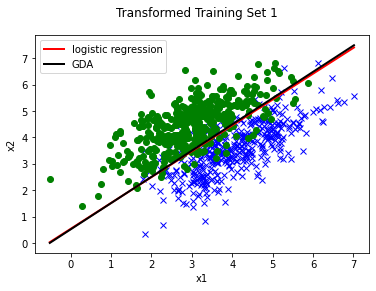

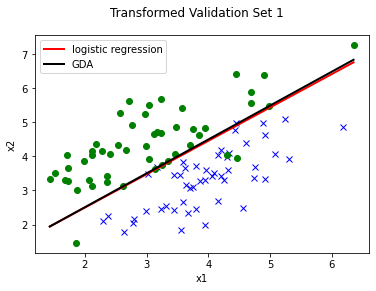

In [15]:
x_train, y_train = util.load_dataset(ds1_training_set_path)
x_valid, y_valid = util.load_dataset(ds1_valid_set_path)
transformed_x_train = np.stack((x_train[:,0], np.log(x_train[:,1])), axis=1)
transformed_x_valid = np.stack((x_valid[:,0], np.log(x_valid[:,1])), axis=1)

# Train logistic regression
transformed_x_train_with_intercept = util.add_intercept(transformed_x_train)
log_reg = LogisticRegression()
log_reg.fit(transformed_x_train_with_intercept, y_train)

# Train GDA
gda = GDA()
gda.fit(transformed_x_train, y_train)

# Plot decision boundaries on training set 1
plot(transformed_x_train, y_train, theta_1=log_reg.theta, legend_1='logistic regression', theta_2=gda.theta, legend_2='GDA', title='Transformed Training Set 1')

# Plot decision boundaries on validation set 1
plot(transformed_x_valid, y_valid, theta_1=log_reg.theta, legend_1='logistic regression', theta_2=gda.theta, legend_2='GDA', title='Transformed Validation Set 1')

Now we can see that logistic regression and GDA have pretty much the same performance on dataset 1.